# COGS 189 Final Project: BCI Competition II Data Set IV

## Literature Review:

#### Single-trial EEG classification of motor imagery using deep convolutional neural networks:

   This paper describes a new method which they proposed that uses a deep convolutional neural network in order to do feature extraction and classification. They built a 5 layer cnn model to classify left and right hand movement. The results of this paper show that conovlutional neural networks has better classification performance than the other three more commonly used methods. 
   
https://www.sciencedirect.com/science/article/abs/pii/S0030402616312980

#### Designing optimal spatial filters for single-trial EEG classification in a movement task:

   This paper goes in depth about how using spatial filters for multi-channel EEG data can lead to signals to discriminate between two conditions. They showed the effectiveness of these filters by classifying EEGs of preparation of movements of the index fingers or the right foot. They used Common Spatial Patterns to get their results. They found that with these methods, they got high prediction rates which makes it to be a promising tactic.
   
https://www.sciencedirect.com/science/article/abs/pii/S1388245798000388
    

#### Classifying Single Trial EEG: Towards Brain Computer Interfacing:

   This is the paper where the data for the BCI competition was obtained from. In this experiment, "the subject sat in a normal chair, relaxed arms resting on the table, fingers in the standard typing position at the computer keyboard. The task was to press with the index and little fingers the corresponding keys in a self-chosen order and timing. The experiment consisted of 3 sessions of 6 minutes each, preand postceeded by 60 seconds relaxing phase." (Blankertz et al). 

https://proceedings.neurips.cc/paper/2001/file/2d579dc29360d8bbfbb4aa541de5afa9-Paper.pdf

#### BCI Competition 2003—Data Set IV:An Algorithm Based on CSSD and FDA for Classifying Single-Trial EEG

Ollie's code:

In [2]:
#Code from Ollie D'amico
import numpy as np
from itertools import chain
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from scipy.signal import butter, sosfiltfilt, sosfreqz  

In [3]:
def listFlatten(l):
    return list(chain.from_iterable(l))

def dc_correct(x):
    # Like baseline correction except it uses entire epoch mean
    nepochs, ntimes, nchans = x.shape
    bl_2D = np.mean(x, axis=1)
    bl_3D = np.transpose(np.repeat(bl_2D, ntimes).reshape(nepochs, nchans, ntimes), (0, 2, 1))

    return np.subtract(x, bl_3D)

def wm(x, start, end, num_points): # Modified from A2
    # Expects x = (num_obs x num_samples x num_channels)
    num_trials = x.shape[0]
    w = np.round((end-start)/num_points).astype(int)
    y = np.zeros((num_points, x.shape[-1], num_trials))
    for i in range(0, num_points):
        s = start + (w * i)
        e = end   + (w * i)
        y[i, :, :] = np.mean(x[:, s:e, :], 1).T
    
    return y

In [4]:
# Load mat
path = '/home/isgonzal/COGS 189/BCI-Machine-Learning/sp1s_aa.mat'
data = loadmat(path)

# Extract relevant pieces of data (y_test is from the website)
clab = data['clab']
x_train = data['x_train']
y_train = data['y_train'].reshape(-1,)
x_test = data['x_test']
y_test = np.array([1,0,0,0,1,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,1,1,0,0,1,0,1,1,1,1,0,0,0,1,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,1,1,0,1,1,0])

# Extract channels into a flattened list
chans = np.array(listFlatten(clab[0]))

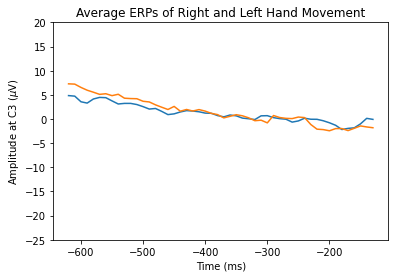

In [5]:
# isolate C3 for plot
ch = np.where(chans == 'C3')[0][0] 

# right hand movements are y_train == 1
x_train_C3_R = x_train[:, ch, np.where(y_train == 1)]
x_train_C3_L = x_train[:, ch, np.where(y_train == 0)]

# Compute averages
avg_C3_R = np.mean(x_train_C3_R, 2)
avg_C3_L = np.mean(x_train_C3_L, 2)

# Plot (right hand plot should look similar to paper's plot)
fs = 100 # Hz
dt = 1000./100 # msec
times = np.arange(-120-500, -120, dt)
plt.plot(times, avg_C3_R);
plt.plot(times, avg_C3_L);
plt.ylim([-25, 20]);
plt.xlabel('Time (ms)');
plt.ylabel('Amplitude at C3 ($\mu$V)');
plt.title('Average ERPs of Right and Left Hand Movement');

In [6]:
# Extract features
sdt = np.round(dt).astype(int); # rounded dt so that we can index samples
n_points = 3
win_e = -130
win_s = win_e - 210

# Index-space window start and end
w_s = np.where(times == win_s)[0][0]
w_e = np.where(times == win_e)[0][0]

# Transpose data for the wm function defined above
x_train_ = np.transpose(x_train, (2, 0, 1)) # for WM
x_test_ = np.transpose(x_test, (2, 0, 1)) # for WM

# Filter the data
fs = 100.0                                         
lp = 5.                       
order = 2                       

# Create our filter coefficient as as a second-order section
# Note: by defining 'fs' we don't divide our windows by the Nyquist
sos = butter(order, lp, analog = False, btype = 'low', output = 'sos', fs = fs)

# Apply 5 Hz lowpass
x_train_ = sosfiltfilt(sos, x_train_, axis= 1)
x_test_ = sosfiltfilt(sos, x_test_, axis= 1)

# Remove DC offset from each epoch
x_train_ = dc_correct(x_train_)
x_test_ = dc_correct(x_test_)

# Compute windowed means and flatten for sklearn
x_train_wm = wm(x_train_, w_s, w_e, n_points)
x_train_wm_ = x_train_wm.reshape(-1, len(chans)*n_points) 

x_test_wm = wm(x_test_, w_s, w_e, n_points)
x_test_wm_ = x_test_wm.reshape(-1, len(chans)*n_points)

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf_lsqrs = LinearDiscriminantAnalysis(solver = 'lsqr',  shrinkage = 'auto')
score_lsqrs = cross_val_score(clf_lsqrs.fit(x_train_wm_, y_train), x_train_wm_, y_train, cv = 5)
print(f'Cross val performance: {np.mean(score_lsqrs)}')

Cross val performance: 0.5349702380952381


In [8]:
# Overfitting just to get a rough idea of our classifier's performance
clf_lsqrs.score(x_train_wm_, y_train)

0.6930379746835443

In [9]:
clf = clf_lsqrs.fit(x_train_wm_, y_train)
clf.score(x_test_wm_, y_test)

0.51

Kareema's code:

Daniel and Isabella's code:

## Visualizations with mne:

In [54]:
import mne
x_train_new = np.transpose(x_train, (2, 1, 0))
x_train_new = sosfiltfilt(sos, x_train_new, axis= 1)
x_train_new
channels = ['F3', 'F1', 'Fz', 'F2', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2',
       'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5',
       'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'O1', 'O2']
info = mne.create_info(
    ch_names = channels,
    ch_types = ['eeg']*28,
    sfreq = 100)
epochs = mne.EpochsArray(x_train_new, info)

(316, 50, 28)

In [61]:
sfreq = 100
eventlength = x_train_new.shape[0]
ev = [i*sfreq*0.01 for i in range(eventlength)]

In [65]:
events = np.column_stack((np.array(ev),
                         np.zeros(eventlength, dtype = int),
                         np.array(y_train)))
events = events.astype(int)
events

array([[  0,   0,   0],
       [  1,   0,   1],
       [  2,   0,   0],
       [  3,   0,   1],
       [  4,   0,   0],
       [  5,   0,   1],
       [  6,   0,   0],
       [  7,   0,   1],
       [  8,   0,   0],
       [  9,   0,   0],
       [ 10,   0,   1],
       [ 11,   0,   1],
       [ 12,   0,   0],
       [ 13,   0,   0],
       [ 14,   0,   1],
       [ 15,   0,   1],
       [ 16,   0,   1],
       [ 17,   0,   0],
       [ 18,   0,   0],
       [ 19,   0,   1],
       [ 20,   0,   0],
       [ 21,   0,   0],
       [ 22,   0,   1],
       [ 23,   0,   0],
       [ 24,   0,   1],
       [ 25,   0,   0],
       [ 26,   0,   0],
       [ 27,   0,   0],
       [ 28,   0,   0],
       [ 29,   0,   0],
       [ 30,   0,   0],
       [ 31,   0,   0],
       [ 32,   0,   1],
       [ 33,   0,   1],
       [ 34,   0,   1],
       [ 35,   0,   1],
       [ 36,   0,   1],
       [ 37,   0,   1],
       [ 38,   0,   0],
       [ 39,   0,   1],
       [ 40,   0,   0],
       [ 41,   0

    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_374/1991489676.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.plot_psd()


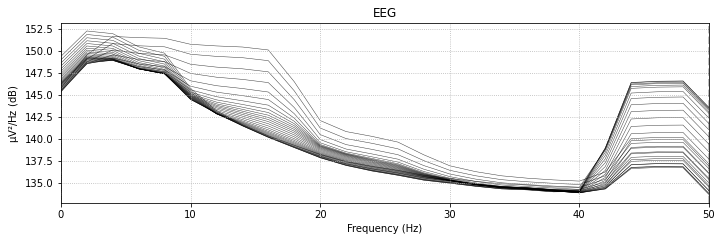

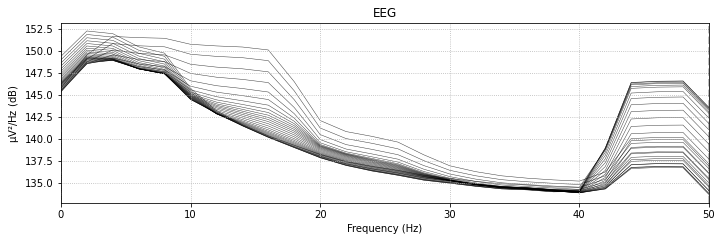

In [59]:
epochs.plot_psd()

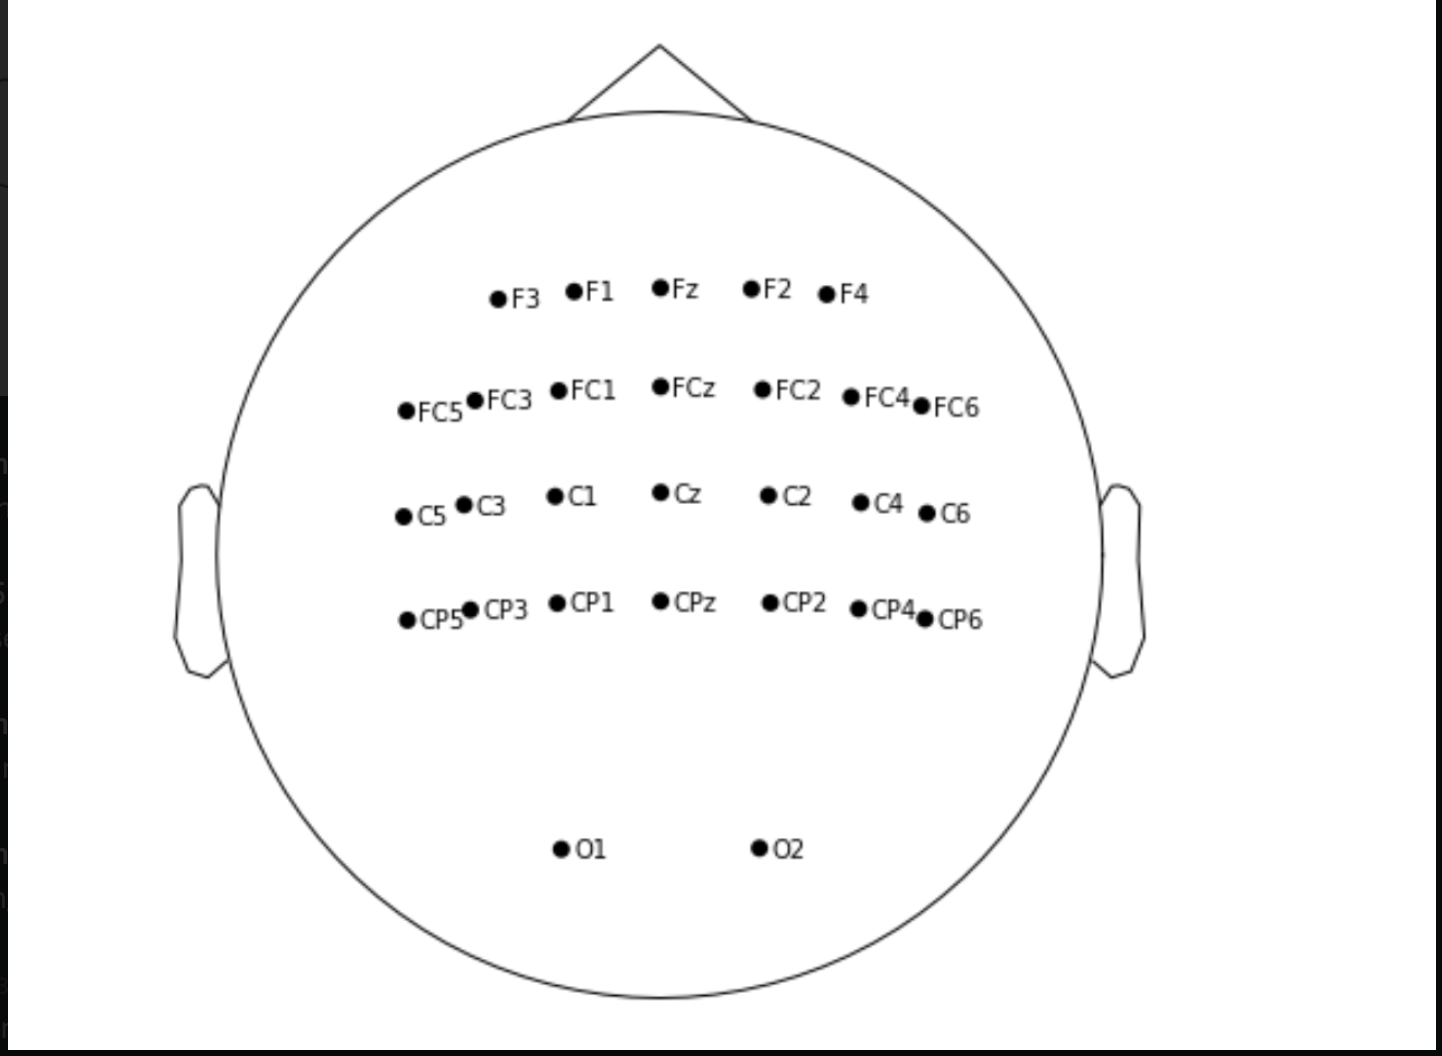

## Random Forest Classification

### Random Forest Classification and accuracy

In [10]:
from sklearn.ensemble import RandomForestClassifier
#using random forest to classify data with dimensionality reduced to first feature
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(x_train_wm_, y_train)

# Predicting the Test set results
pred = classifier.predict(x_test_wm_)
pred

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0], dtype=uint8)

In [11]:
classifier.score(x_test_wm_, y_test)

0.53

### Random Forest Confusion Matrix

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, pred)

print(confusion_matrix)
#array that depicts the True Positives, False Positives, False Negatives, and True negatives.

[[29 20]
 [27 24]]


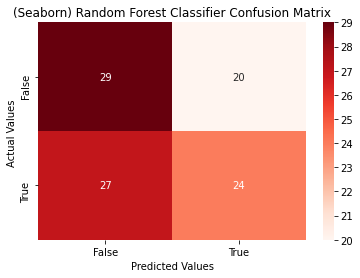

In [13]:
import seaborn as sns

ax = sns.heatmap(confusion_matrix, annot=True, cmap='Reds')

ax.set_title('(Seaborn) Random Forest Classifier Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## labels 
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


plt.show()

### Random Forest ROC Curve

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score1 = classifier.predict_proba(x_test_wm_)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score1))


roc_auc_score for Random Forest:  0.5142056822729091


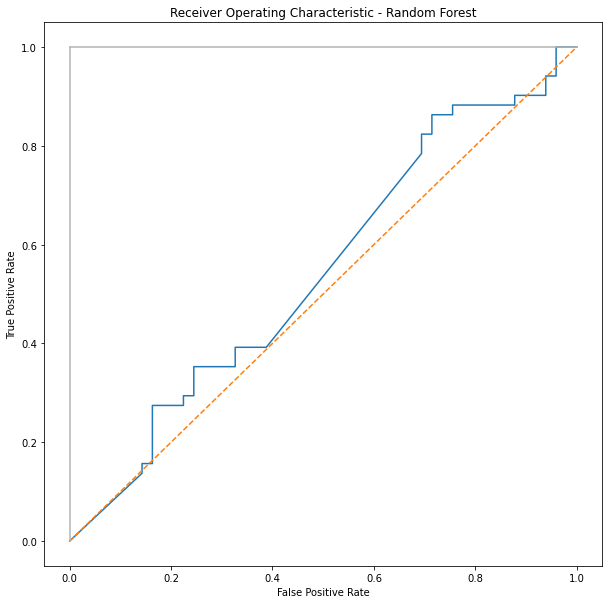

In [46]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Support Vector Machines: Linear and Non Linear Classification

### SVM: Linear Kernel Classification and Accuracy

In [16]:
from sklearn import svm

SVM = svm.LinearSVC()
SVM.fit(x_train_wm_, y_train)
pred = SVM.predict(x_test_wm_)
pred

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


array([0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1], dtype=uint8)

In [17]:
SVM.score(x_test_wm_, y_test)

0.58

### SVM (Linear kernel): Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, pred)
print(confusion_matrix)

[[28 21]
 [21 30]]


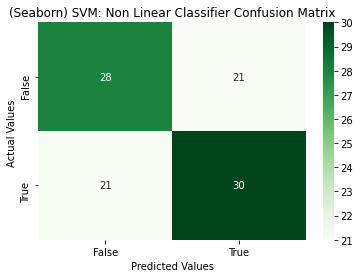

In [19]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Greens')

ax.set_title('(Seaborn) SVM: Non Linear Classifier Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

##labels 
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


plt.show()

### SVM (Linear Kernel): ROC Curve

In [ ]:
## Cant get this to work

### SVM: Radial Kernel Classification and Accuracy

In [20]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf', probability=True)
svclassifier.fit(x_train_wm_, y_train)
pred = svclassifier.predict(x_test_wm_)
pred

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1], dtype=uint8)

In [21]:
svclassifier.score(x_test_wm_,y_test)

0.46

### SVM (Radial Kernel): Confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, pred)
print(confusion_matrix)

[[21 28]
 [26 25]]


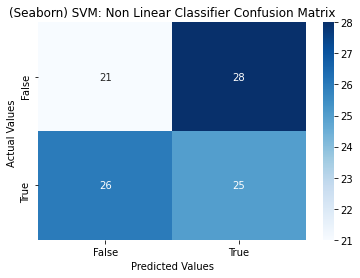

In [23]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

ax.set_title('(Seaborn) SVM: Non Linear Classifier Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

##labels 
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


plt.show()

### SVM (Radial Kernel): ROC Curve

In [24]:
y_score1 = svclassifier.predict_proba(x_test_wm_)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

print('roc_auc_score for non linear svc: ', roc_auc_score(y_test, y_score1))

roc_auc_score for non linear svc:  0.5258103241296519


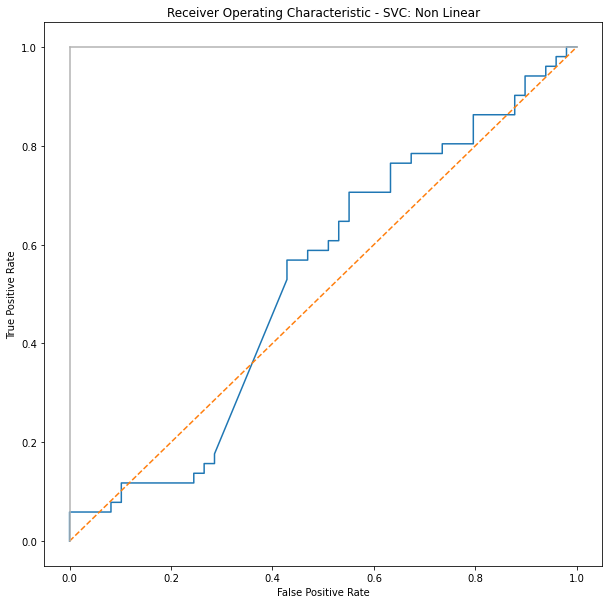

In [25]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVC: Non Linear')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Neural Network Classification

### NN Training and accuracy score

In [26]:
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
NN.fit(x_train_wm_, y_train)
pred = NN.predict(x_test_wm_)
pred 

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1], dtype=uint8)

In [27]:
NN.score(x_test_wm_, y_test)

0.52

### NN Confusion Matrix

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, pred)
print(confusion_matrix)

[[32 17]
 [31 20]]


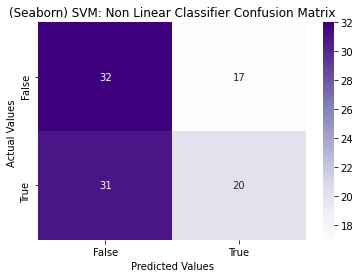

In [29]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Purples')

ax.set_title('(Seaborn) SVM: Non Linear Classifier Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

##labels 
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


plt.show()

### NN ROC curve

In [30]:
y_score1 = NN.predict_proba(x_test_wm_)[:,1]
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)

print('roc_auc_score for non linear svc: ', roc_auc_score(y_test, y_score1))

roc_auc_score for non linear svc:  0.5440176070428171


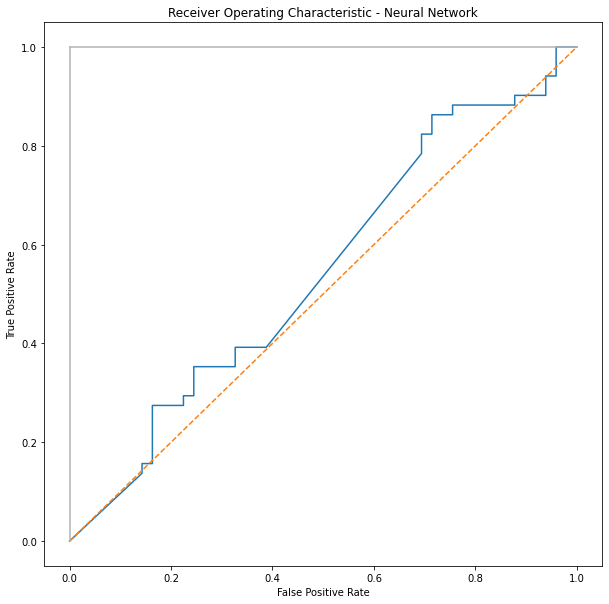

In [31]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Neural Network')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Trying to Reduce Dimensionality with PCA

In [32]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

pca = PCA()
Xtrain = pca.fit_transform(x_train_wm_)
xtest = pca.transform(x_test_wm_)

In [47]:
#how much of the variance does the first feature have?
explained_variance = pca.explained_variance_ratio_
explained_variance[0] 
#explained variance for the first principal component is 78, which means 78% of the data's information is explained through this variable

0.04092559864259482

In [36]:
explained_variances = []
for i in range(len(explained_variance)):
    explained_variances.append(explained_variance[i])
 
print(explained_variances)

1.0
[0.04092559864259482, 0.03865121598654108, 0.03724317604828167, 0.03434516500596301, 0.03315490531724508, 0.03158637732422201, 0.030511986886862786, 0.0289322372156225, 0.027379518364806545, 0.02651160125445928, 0.025728209853758108, 0.025471152870971483, 0.025121167663740465, 0.023661701289658485, 0.02281755461403812, 0.02179929786482277, 0.02074589442009378, 0.0203838890030686, 0.019273354549428502, 0.018586394194158844, 0.017890710144066062, 0.017342009338119635, 0.01609458096990957, 0.015383525054261939, 0.01519684162907835, 0.014880748422837101, 0.014325029804634378, 0.013883163768559132, 0.013436788022348906, 0.012906539332308753, 0.012350393000934087, 0.012179642420893515, 0.011568110883139453, 0.011333486670351695, 0.01105099573907846, 0.010734966437024089, 0.010497543882100231, 0.010329482328388756, 0.0097146464094126, 0.009492583287748602, 0.008945963905437643, 0.008704183862410418, 0.008353698996547948, 0.008009743777246175, 0.00740364535035949, 0.0073242671331463826, 0.

In [44]:
k=0
current=0
total=sum(explained_variances)
while current/total<0.96:
    current+=explained_variances[k]
    k+=1
k

65

^This shows that 65 out of 84 total principal components make up 96% of the data, so now we would want to try classifying with only those

### Using Only The First 65 Principal Components on Random Forest:

In [38]:
#training data with first principal component
pca = PCA(n_components=65)
Xtrain = pca.fit_transform(x_train_wm_)
xtest = pca.transform(x_test_wm_)

In [41]:
from sklearn.ensemble import RandomForestClassifier
#using random forest to classify data with dimensionality reduced to first feature
classifier2 = RandomForestClassifier(max_depth=2, random_state=0)
classifier2.fit(x_train_wm_, y_train)

# Predicting the Test set results
pred = classifier2.predict(x_test_wm_)
pred

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0], dtype=uint8)

In [42]:
classifier2.score(x_test_wm_, y_test)

0.53

Out of 84 principal components, it takes 65 to explain 96% of the variance in the data, so we dont see much change in the accuracy of the classification algorithm. 

Where we got our code inspiration from:

https://www.projectpro.io/recipes/plot-roc-curve-in-python

https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/

https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/

https://stackabuse.com/classification-in-python-with-scikit-learn-and-pandas/

https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/
